In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-08-13 07:54:33.165191


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-3.3445)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(10.3650)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(23.0770)
train_loss:  -4.785567154514789
valid_loss:  -4.348766040420533
h_min_tilde -6.1621056 ell_tilde -4.698206931695937 kappa_tilde 0.00041325156065300005
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -2.642826882350445
valid_loss:  -3.041024132013321
weight_alpha 1.0 h_min_tilde -6.1621056 ell_tilde -2.72246633228302 kappa_tilde 0.0002695960704008129


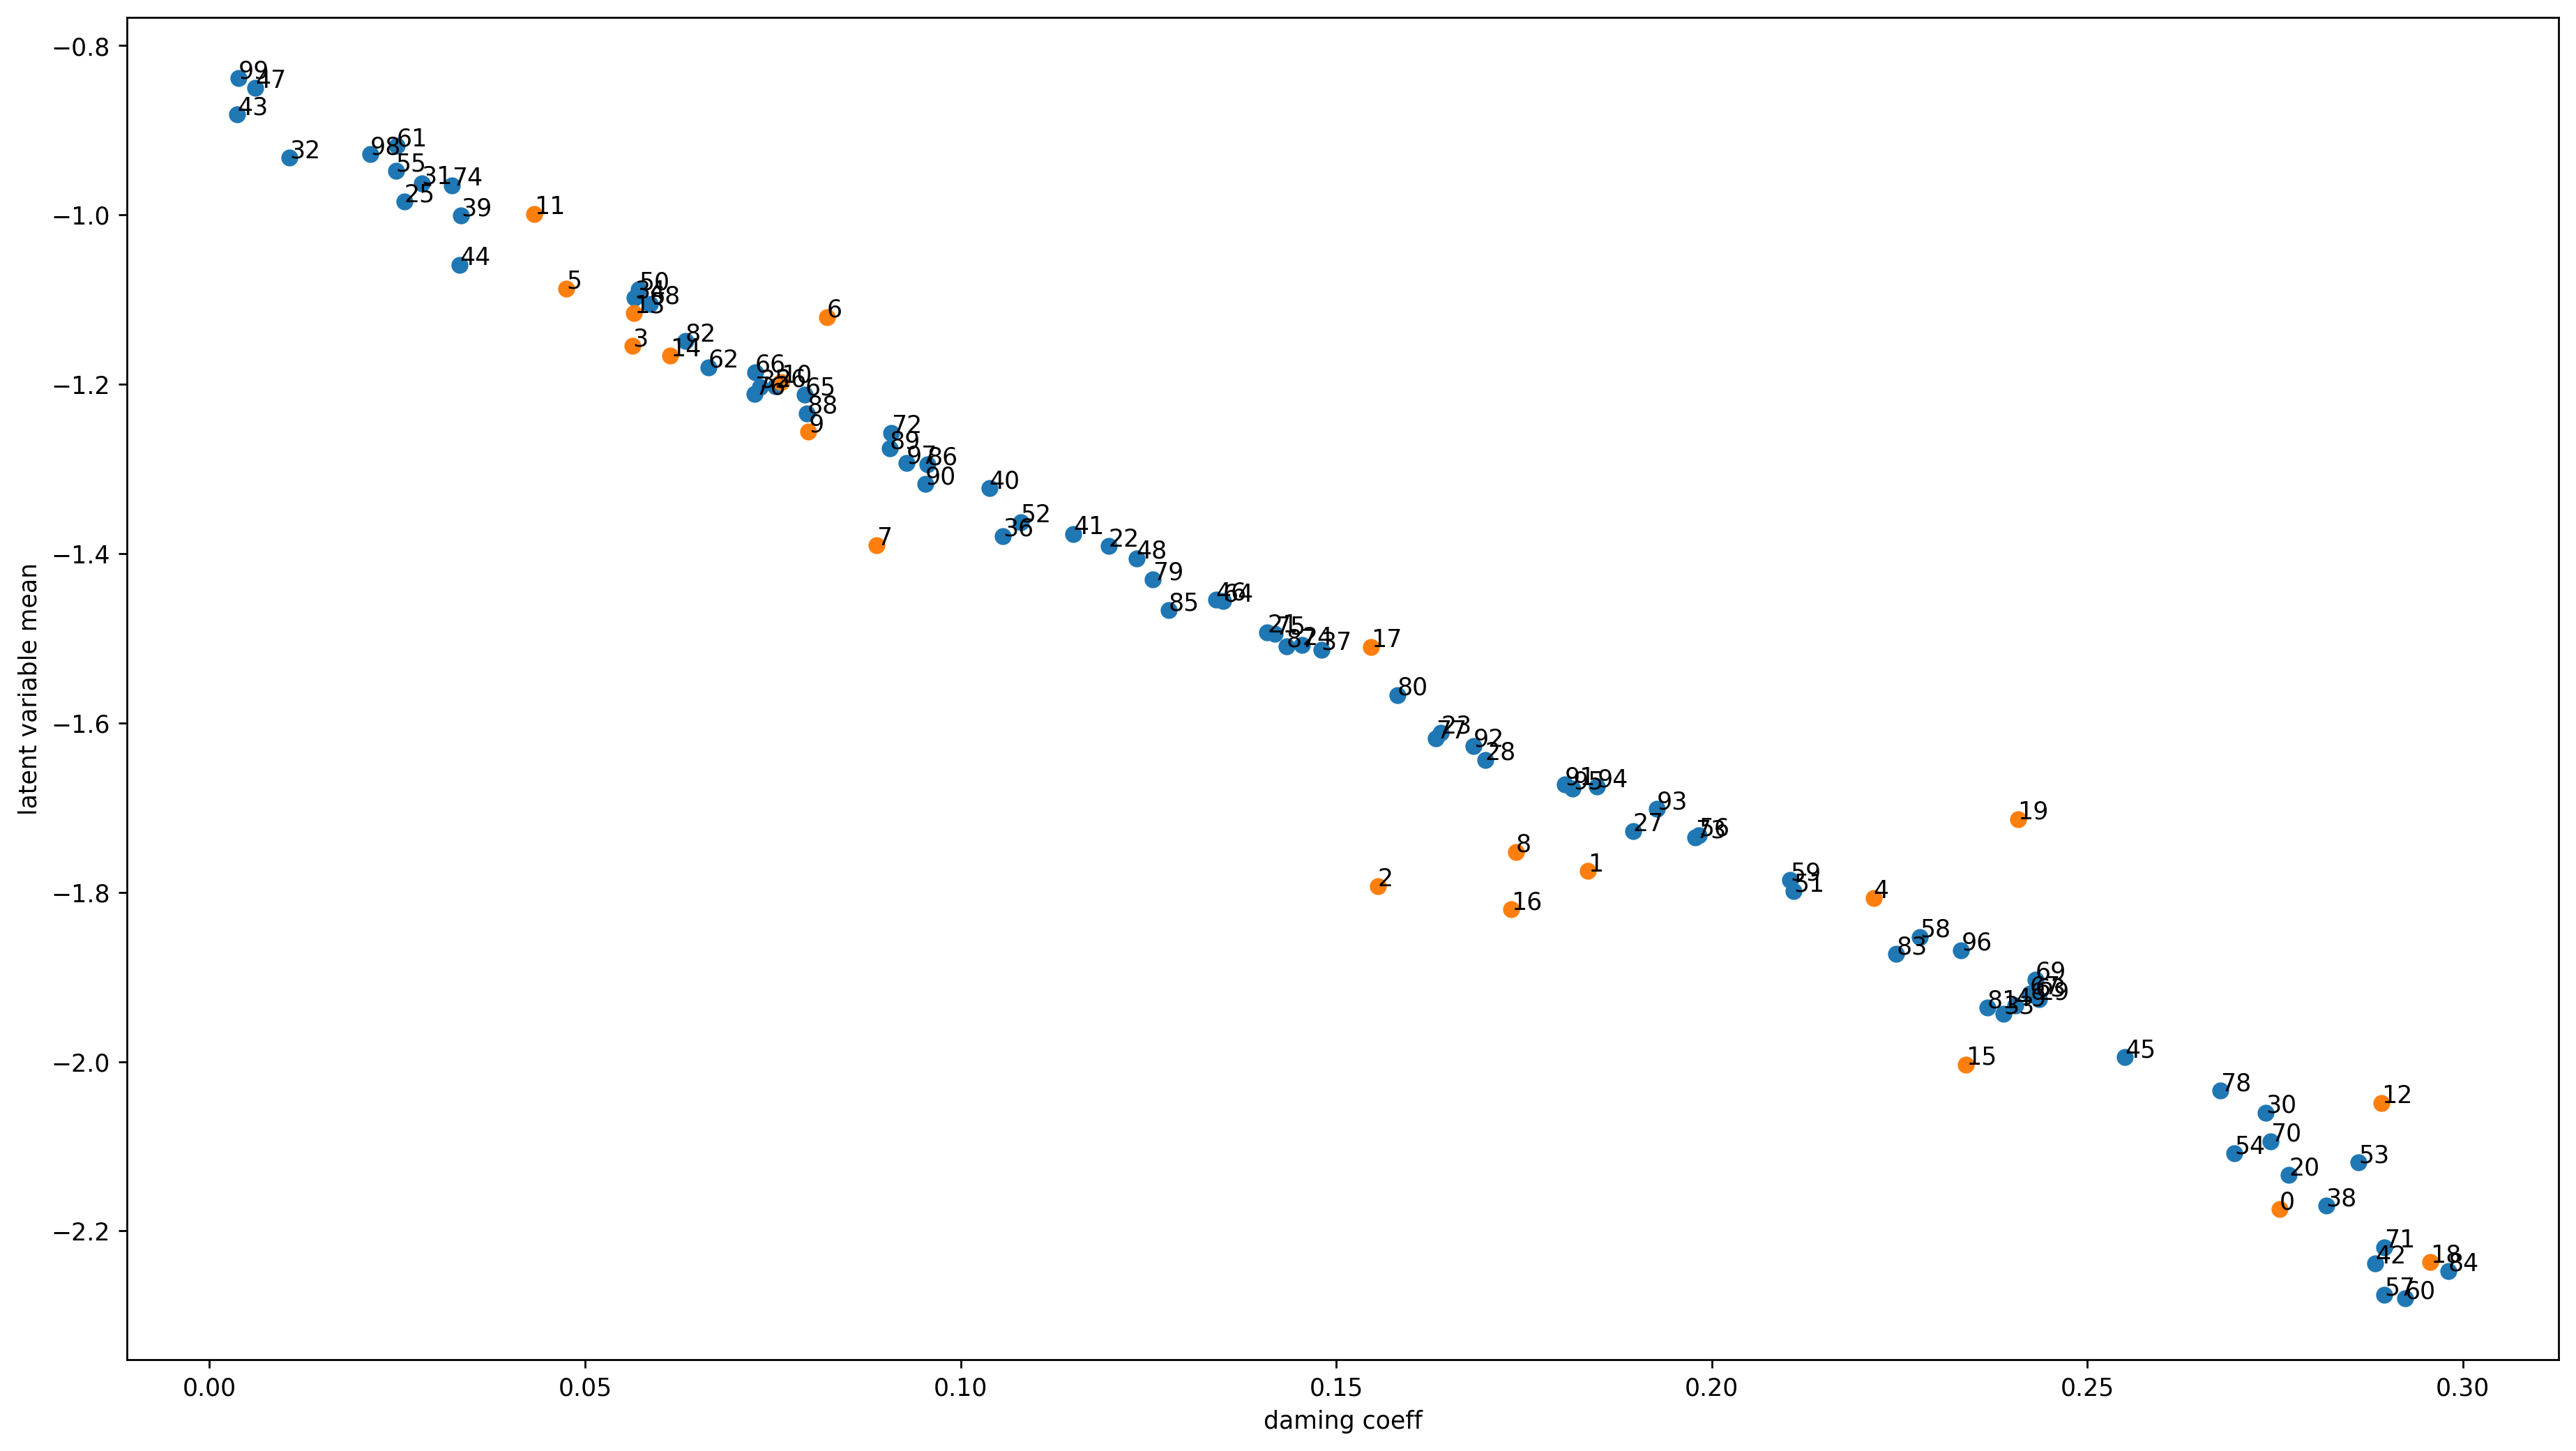

[0.27558327 0.18352316 0.1555254  0.05631637 0.22153209 0.04749296
 0.08222594 0.08882398 0.17395134 0.07974574]
[0.07607646 0.04324929 0.28917916 0.0565244  0.06136666 0.23385438
 0.17329886 0.15464178 0.29568732 0.24074907]
[0.27682488 0.14084651 0.11968344 0.16393695 0.14547932 0.02595771
 0.07537353 0.18952982 0.1698246  0.24357072]
[0.27378803 0.02826082 0.01065271 0.23884282 0.05660032 0.07328726
 0.10562848 0.14802452 0.28178981 0.03350773]
[0.10380845 0.11502272 0.28833092 0.00371082 0.03333322 0.25499401
 0.13398235 0.00611741 0.12341508 0.24042046]
[0.05714333 0.21088262 0.10799496 0.28608915 0.26957135 0.02482157
 0.19825332 0.28954726 0.22772974 0.21046585]
[0.29230484 0.02491633 0.06644483 0.24309427 0.13492307 0.07927151
 0.0726323  0.24233323 0.05860339 0.24308566]
[0.2744203  0.28949899 0.09075543 0.19782518 0.03224686 0.14184845
 0.07255772 0.16326971 0.26769998 0.12559623]
[0.15815365 0.23670303 0.0633423  0.22457274 0.2980512  0.1276912
 0.09559393 0.14338239 0.07956

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.470036745071411

 2 5.6484503746032715

 3 3.670502185821533

 4 6.696788787841797

 5 7.014206171035767

 6 6.652415990829468

 7 6.552864074707031

 8 6.8987510204315186

 9 6.873036861419678

 10 6.736211061477661

 11 6.789199352264404

 12 6.8467698097229

 13 6.629623174667358

 14 3.4713456630706787

 15 3.5151917934417725

 16 3.3912034034729004

 17 3.4652669429779053

 18 3.478087902069092

 19 5.630415916442871

 20 6.822152614593506

 21 4.3871073722839355

 22 7.022775411605835

 23 4.039328098297119

 24 3.499408483505249

 25 3.4785914421081543

 26 3.4434337615966797

 27 3.534965753555298

 28 3.805516481399536

 29 7.069286108016968

 30 6.494259357452393

 31 3.9519712924957275

 32 7.063055038452148

 33 7.243983507156372

 34 6.835181951522827

 35 5.764328956604004

 36 3.61906099319458

 37 3.5228219032287598

 38 3.4872636795043945

 39 3.6078314781188965

 40 3.568061351776123

 41 3.5168564319610596

 42 3.467179775238037

 43 5.1928980350494385

 44 3.9

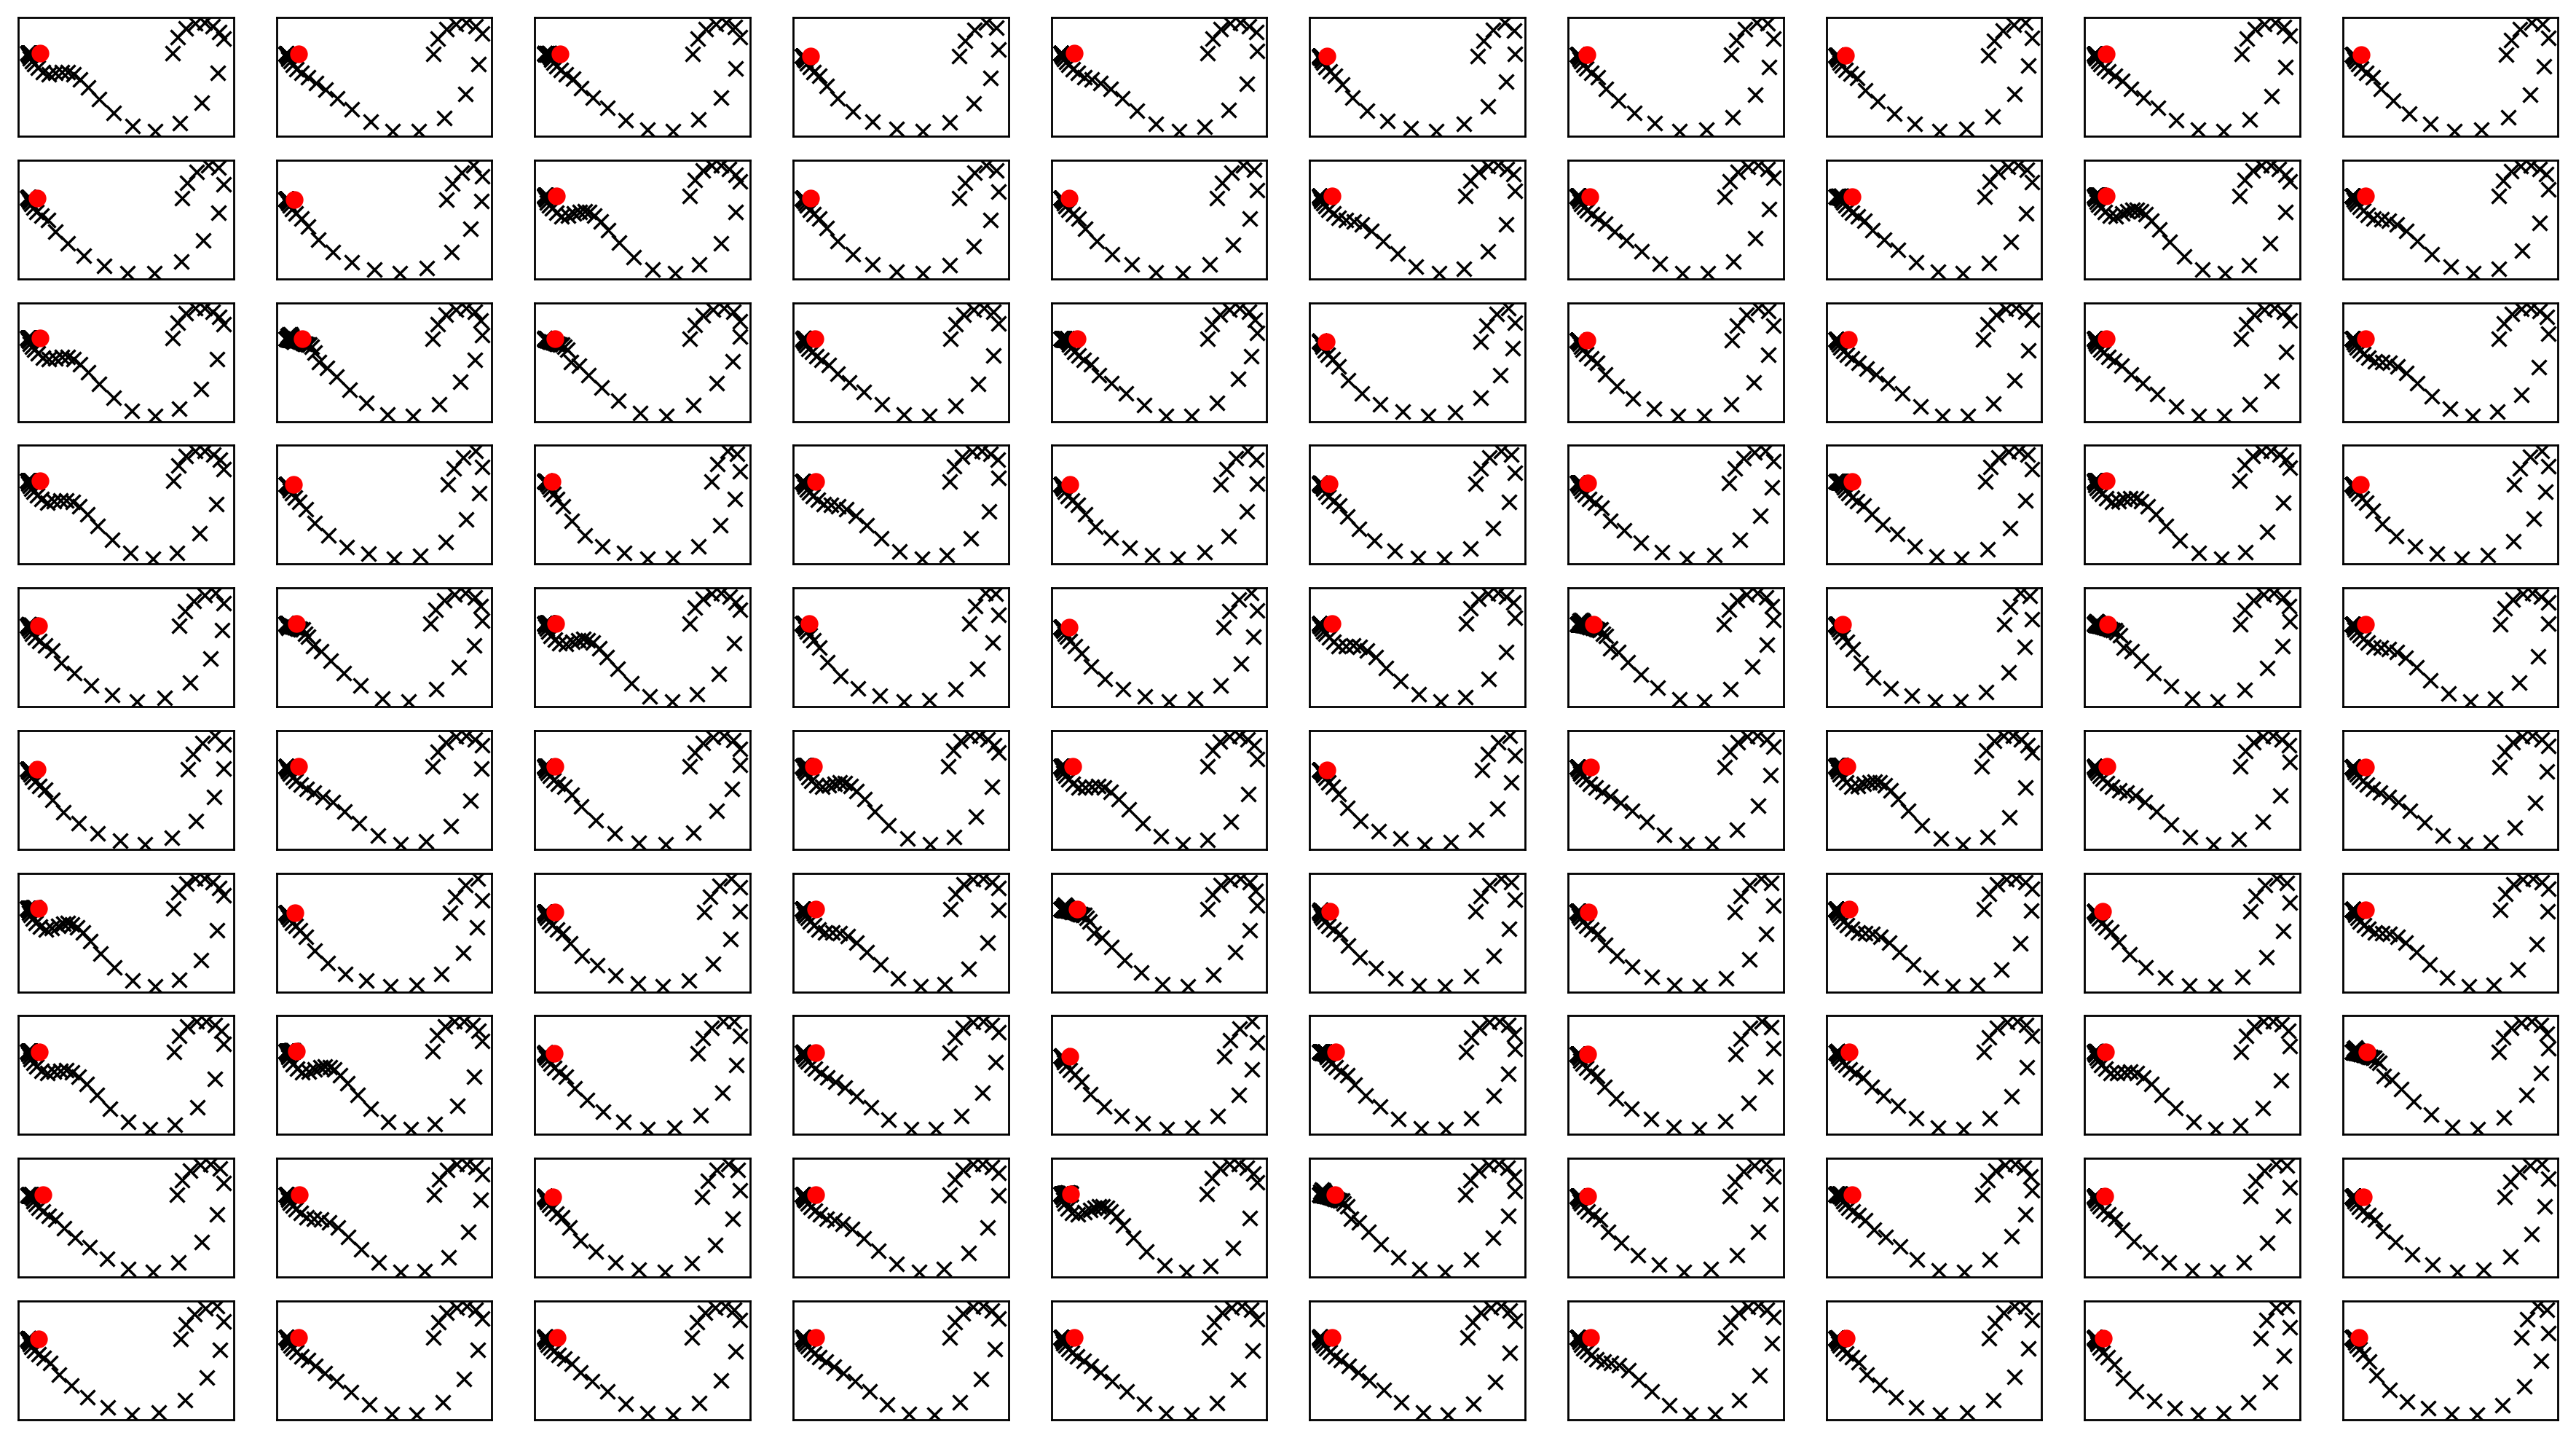

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 7.152557373046875e-07

 1 3.632164239883423

 2 3.3853657245635986

 3 3.6678783893585205

 4 6.415421485900879

 5 7.360351324081421

 6 5.98576021194458

 7 4.5967583656311035

 8 3.924663543701172

 9 7.256920576095581

 10 7.027220726013184

 11 7.142092227935791

 12 7.210489749908447

 13 7.075112342834473

 14 5.0537872314453125

 15 7.247134447097778

 16 6.9248716831207275

 17 6.9971535205841064

 18 4.946461200714111

 19 3.380664587020874

 20 3.6268763542175293

 21 3.761190176010132

 22 3.712259531021118

 23 4.411302089691162

 24 6.614787340164185

 25 7.258775949478149

 26 7.504167795181274

 27 4.652326583862305

 28 5.311603546142578

 29 3.9667699337005615

 30 5.866029262542725

 31 7.438880681991577

 32 7.332775354385376

 33 8.268482446670532

 34 6.3886237144470215

 35 3.9336249828338623

 36 5.174637794494629

 37 7.689920902252197

 38 5.455934047698975


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())